In [1]:
#Choosing training/validation for Y3

#50/50 : start with 150 deg^2, 250 deg^2, 350 deg^2 – converge on limit for size
#*Random selection of parts of 624deg^2 to show invariance or not
#**reserve part of overlap region for science**

import os, sys
import esutil
import healpy as hp
import numpy as np
import fitsio
%matplotlib inline

%load_ext autoreload
%autoreload 2

#for only galaxies: EXTENDED_CLASS_MASH_SOF = 3 apply this cut (this is the same as Y1 MODEST cut)

In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [2]:
sys.path.append('../')
from xd import *
from run_DMASS_Y3 import *
from utils import *
import healpy as hp
from systematics import *
from cmass_modules import io

In [3]:
os.chdir('../../DMASS_XDGMM/code_py3/')
print(os.getcwd())

/users/PCON0003/warner785/DMASS_XDGMM/code_py3


In [4]:
from xdgmm import XDGMM as XDGMM_Holoien

In [5]:
def _FindOptimalN_with_err( N, Xdata, Xcov, pickleFileName = None, suffix = None):
    #from sklearn.mixture import GMM
    #data, _ = mixing_color(data, suffix = suffix)
    @pickle_results( pickleFileName )
    def compute_GMM( N, covariance_type='full', n_iter=1000):
        models = [None for n in N]
        for i in range(len(N)):
            sys.stdout.write("\r" + 'Finding optimal number of cluster : {:0.0f} % '\
                             .format(i * 1./len(N) * 100.))
            sys.stdout.flush()
            models[i] = GaussianMixture(n_components=N[i], max_iter=n_iter,
                            covariance_type=covariance_type)
            models[i].fit(Xdata, Xcov)
        return models
    
    models = compute_GMM(N)
    AIC = [m.aic(Xdata) for m in models]
    BIC = [m.bic(Xdata) for m in models]
    i_best = np.argmin(BIC)
    gmm_best = models[i_best]
    sys.stdout.write("\r" + 'Finding optimal number of cluster : {:0.0f} % '\
                     .format(100))
    print("\nbest fit converged:", gmm_best.converged_, end=' ')
    print(" n_components =  %i" % N[i_best])
    return N[i_best], AIC, BIC

def XDnew_fitting_X( X = None, Xcov=None, 
        FileName = None, 
        #init_params = None, 
        #suffix='', 
        #mag = ['MAG_MODEL', 'MAG_DETMODEL'],
        #err = [ 'MAGERR_MODEL','MAGERR_DETMODEL'],
        #filter = ['G', 'R', 'I'],
        n_cl = None, n_iter = 500, tol=1E-5, method='Bovy', verbose=False ):

    

    try: 
        xdgmm_obj = XDGMM_Holoien(filename=FileName) 
        print ('Using precomputed results from ', FileName)
        return xdgmm_obj
    except FileNotFoundError: pass
    
    if X is None:
        # calling pre-computed model
        xdgmm_obj = XDGMM_Holoien(filename=FileName) 
        print ('Using precomputed results from ', FileName)
        return xdgmm_obj

    else: 
        if n_cl == None : 
            param_range=np.arange(2, 50, 2)
            optimal_n_comp,_,_= _FindOptimalN_with_err( param_range, X, Xcov, 
            pickleFileName = FileName+'.n_cluster' , suffix = '')
            
            #xdgmm_test = XDGMM_Holoien( n_iter=n_iter, tol=tol, method=method )
            ## Define the range of component numbers, and get ready to compute the BIC for each one:
            #param_range = np.arange(2, 50, 2)
            ## Loop over component numbers, fitting XDGMM model and computing the BIC:
            #bic, optimal_n_comp, lowest_bic = xdgmm_test.bic_test(X, Xcov, param_range)
            ##n_cl = optimal_n_comp[np.argmin(bic)]
        else: optimal_n_comp = n_cl

        #import time
        # fitting
        #initiated class
        xdgmm_obj = XDGMM_Holoien( n_components=optimal_n_comp, n_iter=n_iter, tol=tol, method=method )
        #xdgmm.n_components = optimal_n_comp
        print ('n_components=', optimal_n_comp)
        print ('fitting started. This will take for a while.')
#        t1 = time.time()
        xdgmm_obj = xdgmm_obj.fit(X, Xcov)
        #t2 = time.time()
        print ('fitting finished')
        
        #t3 = time.time()
        print ('saving xdgmm object to.. ', FileName)
        xdgmm_obj.save_model(FileName)
        print ('file saved')
        #print ('saving obj. time:', (t3-t2)%60,'s')
        
        #t4 = time.time()
        xdgmm_obj = XDGMM_Holoien(filename=FileName) 
        #print ('loading obj. time:', (t4-t3)%60,'s')
#        t2 = time.time()
#        print ('elapsed time:', (t2-t1)/60.0,'s')
        return xdgmm_obj

In [6]:
os.chdir('../../DMASSY3/code_py3/')
print(os.getcwd())

/users/PCON0003/warner785/DMASSY3/code_py3


In [7]:
# call required functions from modules 

sys.path.append('code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color, XD_fitting_X, assignCMASSProb, doVisualization_1d
from run_DMASS_Y3 import priorCut_test

# Calling Y3 GOLD v2.0 (training)
# All catalogs are in the 'input_path' directory 
# The 'SearchAndCallFits' function below loads all 
# catalogs in the directory including 'input_keyword' in its name
#input_path = '/n/des/lee.5922/data/gold_cat_Y3/STRIPE82/feae9705305d4430993687930f1cc3ad/'
input_path = '/fs/scratch/PCON0003/warner785/bwarner/'
# call only first 9 catalogs for a fast run.
# to call all catalogs in the directory, use 'Y3_GOLD' as input_keyword 
# but that will consume huge memory
input_keyword = 'Y3_GOLD_2_0_STRIPE82'  
# Columns to call
columns =  ['RA', 'DEC', 
            'HPIX_4096',     # Healpix in ring order, nside=4096
            'COADD_OBJECT_ID', 
            'SOF_CM_MAG_CORRECTED_G', # mag_[griz]
            'SOF_CM_MAG_CORRECTED_R',
            'SOF_CM_MAG_CORRECTED_I',
            'SOF_CM_MAG_CORRECTED_Z',
            'SOF_CM_MAG_ERR_G',       # mag error_[griz]
            'SOF_CM_MAG_ERR_R',
            'SOF_CM_MAG_ERR_I',
            'SOF_CM_MAG_ERR_Z', 'EXTENDED_CLASS_MASH_SOF', 'MAG_DETMODEL_G', 'MAG_DETMODEL_R', 'MAG_DETMODEL_I', 'MAG_DETMODEL_Z', 
            'MAGERR_DETMODEL_G', 'MAGERR_DETMODEL_R', 'MAGERR_DETMODEL_I', 'MAGERR_DETMODEL_Z',
            'MOF_CM_MAG_CORRECTED_G', 'MOF_CM_MAG_CORRECTED_R', 'MOF_CM_MAG_CORRECTED_I', 'MOF_CM_MAG_CORRECTED_Z',
            'MOF_CM_MAG_ERR_G', 'MOF_CM_MAG_ERR_R', 'MOF_CM_MAG_ERR_I', 'MOF_CM_MAG_ERR_Z']
gold_st82 = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)

# Color/Magnitude cuts to exclude extremely high or low mag/color sources.
# 16 < mag_riz < 24, 0 < (r-i) < 1.5, 0 < (g-r) < 2.5
# These galaxies are less likeliy to be a CMASS, therefore unnecessary. 
# We apply these cuts to reduce the sample size to speed up the codes
mask_magcut = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_magcut]
gold_st82 = gold_st82[(gold_st82['EXTENDED_CLASS_MASH_SOF'] == 3)]

def keepGoodRegion(des, hpInd = False, balrog=None):
    import healpy as hp
    import fitsio
    # 25 is the faintest object detected by DES
    # objects larger than 25 considered as Noise
    
    path = '/fs/scratch/PCON0003/warner785/bwarner/'
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v2_il22_seeil4.0_nside4096ring_redlimcut.fits')
    #LSSGoldmask = fitsio.read(path+'Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits')
    LSSGoldmask = fitsio.read(path+'MASK_Y3LSSBAOSOF_22_3_v2p2.fits')
    ringhp = hp.nest2ring(4096, [LSSGoldmask['PIXEL']])
    #Y1LSSmask_v1_il22seeil4.04096ring_redlimcut.fits
    #frac_cut = LSSGoldmask['FRAC'] > 0.8
    #ind_good_ring = LSSGoldmask['PIXEL'][frac_cut]
    ind_good_ring = ringhp
    
    # healpixify the catalog.
    nside=4096
    # Convert silly ra/dec to silly HP angular coordinates.
    phi = des['RA'] * np.pi / 180.0
    theta = ( 90.0 - des['DEC'] ) * np.pi/180.0

    hpInd = hp.ang2pix(nside,theta,phi,nest=False)
    keep = np.in1d(hpInd, ind_good_ring)
    des = des[keep]
    if hpInd is True:
        return ind_good_ring
    else:
        return des

print(gold_st82.size)    
gold_st82 = keepGoodRegion(gold_st82)
print(gold_st82.size)


Calling catalogs >>>
Y3_GOLD_2_0_STRIPE82_000125.fits
Y3_GOLD_2_0_STRIPE82_000136.fits
Y3_GOLD_2_0_STRIPE82_000040.fits
Y3_GOLD_2_0_STRIPE82_000015.fits
Y3_GOLD_2_0_STRIPE82_000086.fits
Y3_GOLD_2_0_STRIPE82_000047.fits
Y3_GOLD_2_0_STRIPE82_000108.fits
Y3_GOLD_2_0_STRIPE82_000079.fits
Y3_GOLD_2_0_STRIPE82_000076.fits
Y3_GOLD_2_0_STRIPE82_000057.fits
Y3_GOLD_2_0_STRIPE82_000111.fits
Y3_GOLD_2_0_STRIPE82_000084.fits
Y3_GOLD_2_0_STRIPE82_000088.fits
Y3_GOLD_2_0_STRIPE82_000049.fits
Y3_GOLD_2_0_STRIPE82_000063.fits
Y3_GOLD_2_0_STRIPE82_000070.fits
Y3_GOLD_2_0_STRIPE82_000077.fits
Y3_GOLD_2_0_STRIPE82_000042.fits
Y3_GOLD_2_0_STRIPE82_000118.fits
Y3_GOLD_2_0_STRIPE82_000115.fits
Y3_GOLD_2_0_STRIPE82_000028.fits
Y3_GOLD_2_0_STRIPE82_000140.fits
Y3_GOLD_2_0_STRIPE82_000060.fits
Y3_GOLD_2_0_STRIPE82_000089.fits
Y3_GOLD_2_0_STRIPE82_000143.fits
Y3_GOLD_2_0_STRIPE82_000012.fits
Y3_GOLD_2_0_STRIPE82_000001.fits
Y3_GOLD_2_0_STRIPE82_000045.fits
Y3_GOLD_2_0_STRIPE82_000137.fits
Y3_GOLD_2_0_STRIPE82_

In [8]:
#this CMASS used for Y1, and Y3 now:

import fitsio
cmass = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
train_sample = esutil.io.read('/fs/scratch/PCON0003/warner785/bwarner/cmass-dr12v4-S-Reid-full.dat.fits')
#train_sample = esutil.io.read('/global/cscratch1/sd/bwarner/galaxy_DR11v1_CMASS_South-photoObj.fits.gz')
print('total num of train', train_sample.size)
print('\n--------------------------------\n applying DES veto mask to CMASS\n--------------------------------')   
train_sample = keepGoodRegion(train_sample)

#fitsio.write( output_dir+'/cmass_in_st82.fits', train_sample)

print('num of train_sample after des veto', train_sample.size)

total num of train 258884

--------------------------------
 applying DES veto mask to CMASS
--------------------------------
num of train_sample after des veto 61031


In [9]:
# FIGURE 3

#clf_cmass = XD_fitting_X( None, None, pickleFileName = '../output/test/fitting/gauss_cmass_testy3.pkl')               
#clf_no = XD_fitting_X( None, None, pickleFileName = '../output/test/fitting/gauss_no_testy3.pkl')

#call in catalogs
# Assigning CMASS probabilities to Gold Y3 in Stripe 82 Training/Testing Region.
mag = ['MOF_CM_MAG_CORRECTED', 'MAG_DETMODEL']
err = ['MOF_CM_MAG_ERR', 'MAGERR_DETMODEL']
filter = ['G', 'R', 'I']

mask = (gold_st82['RA']>310) & (gold_st82['RA']<360)
mask = mask & (gold_st82['DEC']>-2) & (gold_st82['DEC']<2)
gold_st82_train = gold_st82[mask]

print(gold_st82_train.size)

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_train['RA'], \
                                         gold_st82_train['DEC'],2./3600, maxmatch=1)
cmass_mask_train = np.zeros(gold_st82_train.size, dtype=bool)
cmass_mask_train[mg2] = 1
clean_cmass_data_des_train, nocmass_train = gold_st82_train[cmass_mask_train], gold_st82_train[~cmass_mask_train]

clean_cmass_data_des = clean_cmass_data_des_train

cmass_fraction = clean_cmass_data_des.size*1./gold_st82_train.size

# Validation regions for DES:
#mask1 = (gold_st82['RA']<30)
#mask1 = mask1 & (gold_st82['DEC']>-10) & (gold_st82['DEC']<10)
#gold_st82_v1 = gold_st82[mask1]

mask2 =(gold_st82['RA']>15)&(gold_st82['RA']<41)
mask2 = mask2 & (gold_st82['DEC']>-10) & (gold_st82['DEC']<10)
gold_st82_v2 = gold_st82[mask2]

#mask3 =(gold_st82['RA']>20)&(gold_st82['RA']<50)
#mask3 = mask3 & (gold_st82['DEC']>-10) & (gold_st82['DEC']<10)
#gold_st82_v3 = gold_st82[mask3]

# now:
#cmass_train = clean_cmass_data_des_train
#cmass_val1 = clean_cmass_data_des[~mask_half]

1192126


In [10]:
print(gold_st82_v2.size)
gold_v2_random_ind = np.random.choice(np.arange(gold_st82_v2.size), size = int(gold_st82_v2.size/5))
gold_v2_random = gold_st82_v2[gold_v2_random_ind]
print(gold_v2_random.size)

2761987
552397


In [10]:
cmass_fraction_full = clean_cmass_data_des_train.size *1./gold_st82_train.size
print(cmass_fraction_full)

0.01106678320915742


In [11]:
import numpy as np
nocmass_random_ind = np.random.choice(np.arange(nocmass_train.size), size = int(nocmass_train.size/5))
nocmass_random = nocmass_train[nocmass_random_ind] 

print(nocmass_random.size)
print(clean_cmass_data_des_train.size)

235786
13193


In [12]:
# number of gaussian mixtures
# Set None for a initial run. The algorithm automatically finds an optimal number
n_gold = None 

# number of XD iteration. 
# I set these numbers small for a fast run but generally
# should be run until the XD algorithm converges (more than 10000 iterations)
n_iter_gold = 10000
# tolerance
tol = 1E-5

# Fitted parameters and covariance will be stored as a pickle
outdir = 'output/test/fitting/'
os.makedirs(outdir, exist_ok=True)
gold_xd_bovy_filename = outdir+'gauss_gold_bovyY3_130MOFDET_unfixed.xdgmm'

In [13]:
# Magnitudes and corresponding errors you want to use to train the algorithm. 
# `mixing_color` automatically constructs [mag g, mag r, color (g-r), color (r-i)] and 
# its 4x4 covariance matrix from the input magnitudes. 
# I simply put `SOF_CM_MAG_CORRECTED` magnitudes for now. 
# If you want to use different combinations of mags and colors, 
# modify `mixing_color` or build your own function. 
mag = ['MOF_CM_MAG_CORRECTED', 'MAG_DETMODEL']
err = ['MOF_CM_MAG_ERR', 'MAGERR_DETMODEL']
filter = ['G', 'R', 'I']

# This generates four columns of gold training sample. order : mag r, mag i, (g-r), (r-i)
X_gold, X_gold_cov = mixing_color(clean_cmass_data_des_train, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

In [15]:
# Determine the best number of Gaussian Mixtures to use 
# You might not need this function as this is already included in XDnew_fitting_X()
n_cl_gold,_,_= _FindOptimalN_with_err( np.arange(2, 50, 2), X_gold, None, 
            pickleFileName = gold_xd_bovy_filename+'.n_cluster' , suffix = '')

#n_cl_gold = None

@pickle_results: computing results and saving to 'output/test/fitting/gauss_gold_bovyY3_130MOFDET.xdgmm.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  14


In [14]:
# Fitting start with Bovy's method
clf_gold = XDnew_fitting_X( X_gold, X_gold_cov, FileName = gold_xd_bovy_filename, 
                    n_cl = 22, n_iter = n_iter_gold, tol = tol, method='Bovy')

Using precomputed results from  output/test/fitting/gauss_gold_bovyY3_130MOFDET_unfixed.xdgmm


In [15]:
#Next: noncmass data

# number of gaussian mixtures
# Set None for a initial run. The algorithm automatically finds an optimal number
n_nogold = None 

# number of XD iteration. 
# I set these numbers small for a fast run but generally
# should be run until the XD algorithm converges (more than 10000 iterations)
n_iter_nogold = 15000
# tolerance
tol = 1E-5

# Fitted parameters and covariance will be stored as a pickle
outdir = 'output/test/fitting/'
os.makedirs(outdir, exist_ok=True)
gold_xd_bovy_filename = outdir+'gauss_nogold_bovyY3_130MOFDET_unfixed3.xdgmm'

In [16]:
# Magnitudes and corresponding errors you want to use to train the algorithm. 
# `mixing_color` automatically constructs [mag g, mag r, color (g-r), color (r-i)] and 
# its 4x4 covariance matrix from the input magnitudes. 
# I simply put `SOF_CM_MAG_CORRECTED` magnitudes for now. 
# If you want to use different combinations of mags and colors, 
# modify `mixing_color` or build your own function. 
mag = ['MOF_CM_MAG_CORRECTED', 'MAG_DETMODEL']
err = ['MOF_CM_MAG_ERR', 'MAGERR_DETMODEL']
filter = ['G', 'R', 'I']

# This generates four columns of gold training sample. order : mag r, mag i, (g-r), (r-i)
X_nogold, X_nogold_cov = mixing_color(nocmass_random, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

In [22]:
# Determine the best number of Gaussian Mixtures to use 
# You might not need this function as this is already included in XDnew_fitting_X()
n_cl_nogold,_,_= _FindOptimalN_with_err( np.arange(2, 50, 2), X_nogold, None, 
            pickleFileName = gold_xd_bovy_filename+'.n_cluster' , suffix = '')

#n_cl_gold = None

@pickle_results: computing results and saving to 'output/test/fitting/gauss_nogold_bovyY3_130MOFDET_2.xdgmm.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  48


In [ ]:
# Fitting start with Bovy's method
clf_nogold = XDnew_fitting_X( X_nogold, X_nogold_cov, FileName = gold_xd_bovy_filename, 
                    n_cl = 48, n_iter = n_iter_gold, tol = tol, method='Bovy')

n_components= 48
fitting started. This will take for a while.


/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,


In [12]:
#load in:
clf_dmass = XDGMM_Holoien(filename='output/test/fitting/gauss_gold_bovyY3_130MOFDET_unfixed.xdgmm')
clf_nodmass = XDGMM_Holoien(filename='output/test/fitting/gauss_nogold_bovyY3_130MOFDET_unfixed3.xdgmm')

In [24]:
#testing figure 3
clf_nodmass = clf_nogold 
#clf_dmass = clf_gold

#load in:
#clf_dmass = XDGMM_Holoien(filename='output/test/fitting/gauss_gold_bovyY3_130DETfixed.xdgmm')
#clf_nodmass = XDGMM_Holoien(filename='output/test/fitting/gauss_nogold_bovyY3_130DETfixed.xdgmm')

clf_dmass = XDGMM_Holoien(filename='output/test/fitting/gauss_gold_bovyY3_130MOFDET.xdgmm')
#clf_nodmass = XDGMM_Holoien(filename='output/test/fitting/gauss_gold_bovyY3_130MOFDET_1.xdgmm')

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 50 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)
/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 54 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 62 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 67 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 71 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 75 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 79 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 83 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 88 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 92 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 96 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 50 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)
/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 58 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 62 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 67 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 71 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 75 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 79 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 83 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)
/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 92 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 96 %

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/astroML/density_estimation/xdeconv.py:130: RuntimeWarning: divide by zero encountered in log
  return log_multivariate_gaussian(X, self.mu, T) + np.log(self.alpha)


multiprocessing 100 % 
pbin = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
frac =  [0.00099074 0.07605827 0.13419154 0.18784123 0.22342342 0.29245983
 0.3461763  0.39333106 0.43951916 0.4928088  0.55140618 0.59339623
 0.62486716 0.66577253 0.72308546 0.74786325 0.79531616 0.84286378
 0.88232759 0.91854966]
diff2_reduced:  0.0005614541283855409
size:  20
sum of diff2:  0.011229082567710817


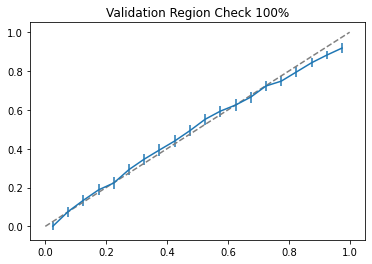

In [13]:
#validation region check 1

#mask = (gold_st82['RA']>310) & (gold_st82['RA']<360)
#mask = mask & (gold_st82['DEC']>-2) & (gold_st82['DEC']<2)
#gold_st82_train = gold_st82[mask]

mag = ['MOF_CM_MAG_CORRECTED', 'MAG_DETMODEL']
err = ['MOF_CM_MAG_ERR', 'MAGERR_DETMODEL']
filter = ['G', 'R', 'I']

mask4 =(gold_st82['RA']>15)&(gold_st82['RA']<41)
mask4 = mask4 & (gold_st82['DEC']>-10) & (gold_st82['DEC']<10)
gold_st82_v4 = gold_st82[mask4]

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_v4['RA'], \
                                         gold_st82_v4['DEC'],2./3600, maxmatch=1)
cmass_mask4 = np.zeros(gold_st82_v4.size, dtype=bool)
cmass_mask4[mg2] = 1
clean_cmass_data_des_v4, nocmass_v4 = gold_st82_v4[cmass_mask4], gold_st82_v4[~cmass_mask4]

clean_dmass_prob4 = assignCMASSProb(clean_cmass_data_des_v4, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter ) 
dmass_st82_real4 = clean_dmass_prob4

dmass_st82_val4 = assignCMASSProb(gold_st82_v4, clf_dmass, clf_nodmass, 
                     cmass_fraction = cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter )


pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
N, _ = np.histogram(dmass_st82_real4['CMASS_PROB'], bins=pbin)
print('pbin =', pbin)
import matplotlib.pyplot as plt
#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

M, _ = np.histogram(dmass_st82_val4['CMASS_PROB'], bins=pbin)

frac = N/M
print('frac = ', frac)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)
#fracerr = (N/M)*np.sqrt((1/N)-(1/M))

x1=frac
x2=pcenter
err=fracerr
diff2 = (x1-x2)**2 
diff2_reduced = sum(diff2)/diff2.size
print("diff2_reduced: ",diff2_reduced)
print("size: ",diff2.size)
print("sum of diff2: ",sum(diff2))

fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
ax.plot([0,1], [0,1], ls='--', color='grey')
#ax.legend(chi2_reduced)
plt.title('Validation Region Check 100%')
fig.savefig('MOFDET_Val_new_check.pdf')

#describe plot: ***used for model and validation sample-- what is done to create plot

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
pbin = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
frac =  [0.0009992  0.07446471 0.1331573  0.18362864 0.23534026 0.29349693
 0.34357785 0.39641771 0.43702081 0.50695909 0.5501355  0.595
 0.65195587 0.68544601 0.73704735 0.77482366 0.81443299 0.84236948
 0.88346526 0.92418773]
chi2_reduced:  0.8268517213692437
size:  20
sum of chi2:  16.537034427384874


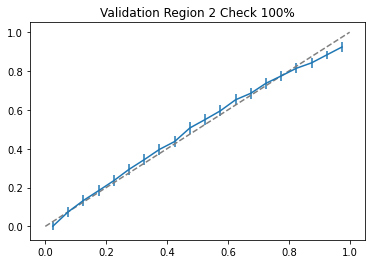

In [26]:
#(Validation 2) Figure 3

mag = ['MOF_CM_MAG_CORRECTED', 'MAG_DETMODEL']
err = ['MOF_CM_MAG_ERR', 'MAGERR_DETMODEL']
filter = ['G', 'R', 'I']

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_v2['RA'], \
                                         gold_st82_v2['DEC'],2./3600, maxmatch=1)
cmass_mask2 = np.zeros(gold_st82_v2.size, dtype=bool)
cmass_mask2[mg2] = 1
clean_cmass_data_des_v2, nocmass_v2 = gold_st82_v2[cmass_mask2], gold_st82_v2[~cmass_mask2]

clean_dmass_prob2 = assignCMASSProb(clean_cmass_data_des_v2, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter ) 
dmass_st82_real2 = clean_dmass_prob2

dmass_st82_val2 = assignCMASSProb(gold_st82_v2, clf_dmass, clf_nodmass, 
                     cmass_fraction = cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter )


pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
N, _ = np.histogram(dmass_st82_real2['CMASS_PROB'], bins=pbin)
print('pbin =', pbin)
import matplotlib.pyplot as plt
#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

M, _ = np.histogram(dmass_st82_val2['CMASS_PROB'], bins=pbin)

frac = N/M
print('frac = ', frac)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)

x1=frac
x2=pcenter
err=fracerr
chi2 = (x1-x2)**2 / err **2 
chi2_reduced = sum(chi2)/chi2.size
print("chi2_reduced: ",chi2_reduced)
print("size: ",chi2.size)
print("sum of chi2: ",sum(chi2))

fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
ax.plot([0,1], [0,1], ls='--', color='grey')
#ax.legend(chi2_reduced)
plt.title('Validation Region 2 Check 100%')
fig.savefig('MOFDET_Val100.pdf')

#describe plot: ***used for model and validation sample-- what is done to create plot

In [27]:
# color distributions

X_sample_dmass = clf_dmass.sample(200000)        # non-cmass model
X_sample_nodmass = clf_nodmass.sample(200000)

mag = ['MOF_CM_MAG_CORRECTED', 'MAG_DETMODEL']
err = ['MOF_CM_MAG_ERR', 'MAGERR_DETMODEL']
filter = ['G', 'R', 'I']

# This generates four columns of cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_cmass_true, X_cmass_cov = mixing_color(clean_cmass_data_des_train, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

# This generates four columns of non-cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_no_true, X_no_cov = mixing_color(nocmass_train, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

Using central 100% to set range.


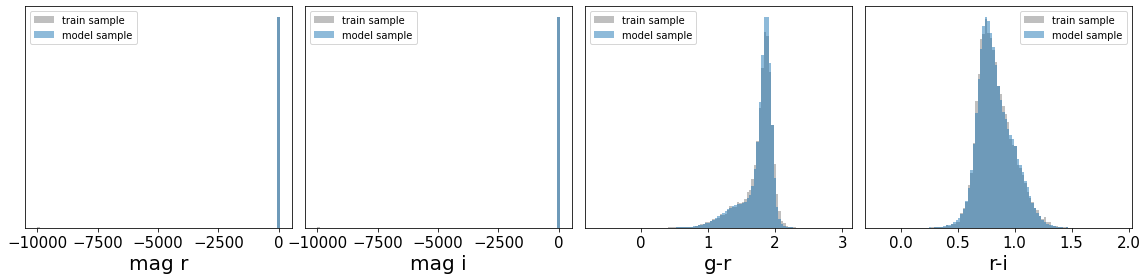

In [28]:
# Comparison. train vs. randoms from the fitted gaussian mixture model
doVisualization_1d( data=[X_cmass_true, X_sample_dmass], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['train sample', 'model sample'], 
                   weight = [None,None], 
                   nbins=100, filename = 'DET_cmass.pdf')

Using central 100% to set range.


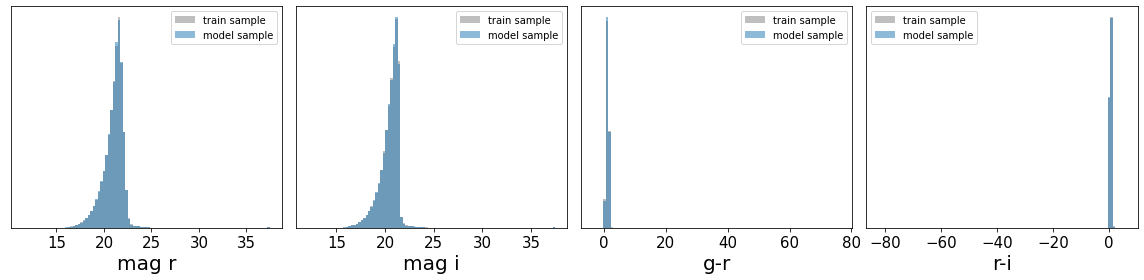

In [29]:
# Comparison. train vs. randoms from the fitted gaussian mixture model
doVisualization_1d( data=[X_no_true, X_sample_nodmass], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['train sample', 'model sample'], 
                   weight = [None,None], 
                   nbins=100, filename = 'DET_nocmass.pdf')

calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
calculate loglikelihood gaussian with multiprocessing module
multiprocessing 100 % 
pbin = [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
frac =  [0.00100353 0.07463364 0.13456639 0.18527697 0.23797319 0.29552677
 0.34344908 0.3986532  0.4466741  0.50338696 0.55333636 0.60040671
 0.65298886 0.68429402 0.73245614 0.77488938 0.81818182 0.83861083
 0.88346526 0.92274939]
chi2_reduced:  0.8946828659232875
size:  20
sum of chi2:  17.89365731846575


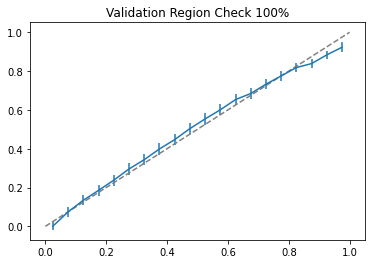

In [30]:
#(Validation new) Figure 3

mag = ['MOF_CM_MAG_CORRECTED', 'MAG_DETMODEL']
err = ['MOF_CM_MAG_ERR', 'MAGERR_DETMODEL']
filter = ['G', 'R', 'I']

mask3 =(gold_st82['RA']>18)&(gold_st82['RA']<43)
mask3 = mask3 & (gold_st82['DEC']>-10) & (gold_st82['DEC']<10)
gold_st82_v3 = gold_st82[mask3]

mg1, mg2, _ = esutil.htm.HTM(10).match(train_sample['RA'], train_sample['DEC'], gold_st82_v3['RA'], \
                                         gold_st82_v3['DEC'],2./3600, maxmatch=1)
cmass_mask3 = np.zeros(gold_st82_v3.size, dtype=bool)
cmass_mask3[mg2] = 1
clean_cmass_data_des_v3, nocmass_v3 = gold_st82_v3[cmass_mask3], gold_st82_v3[~cmass_mask3]

clean_dmass_prob3 = assignCMASSProb(clean_cmass_data_des_v3, clf_dmass, clf_nodmass, 
                     cmass_fraction =cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter ) 
dmass_st82_real3 = clean_dmass_prob3

dmass_st82_val3 = assignCMASSProb(gold_st82_v3, clf_dmass, clf_nodmass, 
                     cmass_fraction = cmass_fraction_full
, 
                     mag=mag, err=err, filter=filter )


pbin = np.linspace(0, 1, 21)
pcenter = pbin[:-1] + 0.025
N, _ = np.histogram(dmass_st82_real3['CMASS_PROB'], bins=pbin)
print('pbin =', pbin)
import matplotlib.pyplot as plt
#pbin, frac, fracerr = np.genfromtxt('../paper_figure/model_probability.txt', unpack=True)

M, _ = np.histogram(dmass_st82_val3['CMASS_PROB'], bins=pbin)

frac = N/M
print('frac = ', frac)
fracerr = 1/np.sqrt(N) #1 / sqrt(number of true cmass galaxies in each bin)

x1=frac
x2=pcenter
err=fracerr
chi2 = (x1-x2)**2 / err **2 
chi2_reduced = sum(chi2)/chi2.size
print("chi2_reduced: ",chi2_reduced)
print("size: ",chi2.size)
print("sum of chi2: ",sum(chi2))

fig, ax = plt.subplots()
ax.errorbar( pcenter, frac, yerr=fracerr)
ax.plot([0,1], [0,1], ls='--', color='grey')
#ax.legend(chi2_reduced)
plt.title('Validation Region Check 100%')
fig.savefig('MOFDET_Valnew.pdf')

#describe plot: ***used for model and validation sample-- what is done to create plot

In [14]:
# color distributions

X_sample_dmass = clf_dmass.sample(200000)        # non-cmass model
X_sample_nodmass = clf_nodmass.sample(200000)

mag = ['MOF_CM_MAG_CORRECTED', 'MAG_DETMODEL']
err = ['MOF_CM_MAG_ERR', 'MAGERR_DETMODEL']
filter = ['G', 'R', 'I']

# This generates four columns of cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_cmass_true, X_cmass_cov = mixing_color(clean_cmass_data_des_train, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

# This generates four columns of non-cmass training sample. order : mag r, mag i, (g-r), (r-i)
X_no_true, X_no_cov = mixing_color(nocmass_train, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

/users/PCON0003/warner785/.conda/envs/DES_env/lib/python3.7/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


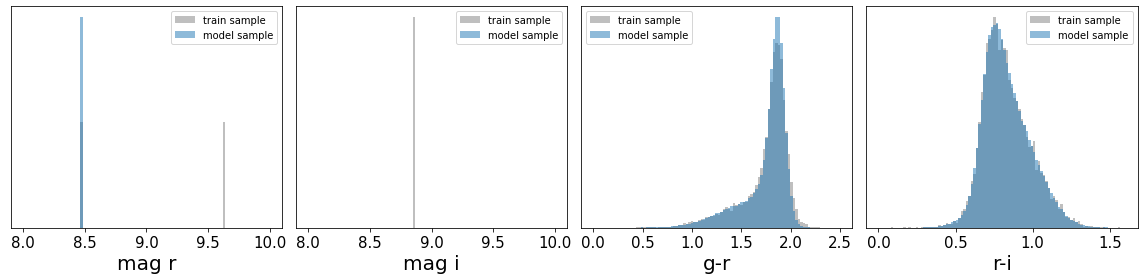

In [26]:
# Comparison. train vs. randoms from the fitted gaussian mixture model
doVisualization_1d( data=[X_cmass_true, X_sample_dmass], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = [(8,10),(8,10),(0,2.5),(0.0,1.6)], 
                   name = ['train sample', 'model sample'], 
                   weight = [None,None], 
                   nbins=100, filename = 'MOFDET_cmass.pdf')

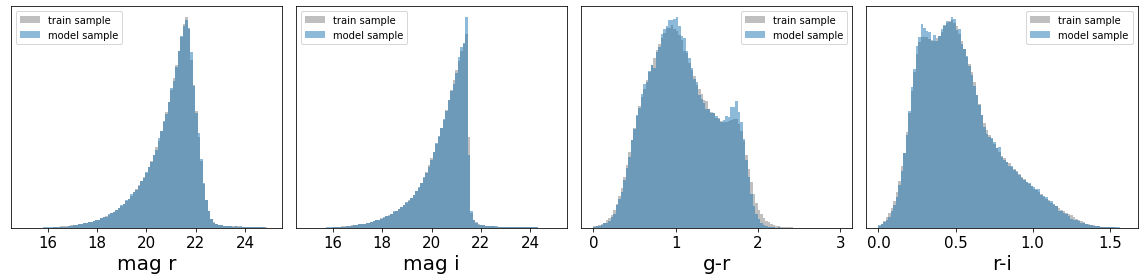

In [20]:
# Comparison. train vs. randoms from the fitted gaussian mixture model
doVisualization_1d( data=[X_no_true, X_sample_nodmass], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = [(15,25),(15,25),(0,3),(0.0,1.6)], 
                   name = ['train sample', 'model sample'], 
                   weight = [None,None], 
                   nbins=100, filename = 'MOFDET_nocmass.pdf')